# Plain XGBoost with expanded and standardized data

In [127]:
# Packages and libraries
import pandas as pd
import xgboost as xgb
import numpy as np

# Load data before standardization
df = pd.read_csv("df_sum_score_ex.csv")

In [128]:
# Splitting the data 
# X is the data which will be used to make predictions, and y contains the data we want to predict.
# We want to predict the score of the students in college, hence y_training and y_test is the college average grade. 

X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_PRO','CC_PRO','ENG_PRO'], axis=1).copy()
# X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_S11','CC_S11','ENG_S11','CR_PRO','CC_PRO','ENG_PRO'], axis=1).copy() 

y=df['COL_GRADE_AVG'].copy()

# Now we will continue to formatting X to make it suitable for making a model with XGBoost. 
# One-hot encoding 

# Look at the different types of data contained in each variable. 
X.dtypes

# The object columns we need to inspect to ensure that they are what we need them to be and after that we will do one-hot encoding. 
# One hot encoding is used to make the categorical varoiable STRATUM work in the model. 
# What is gonna happen is that the categorical variable is becoming multiple columns of binary values. 
# One hot encoding works great for trees and this is the motivation for using this method. 
X_encoded = pd.get_dummies(X,columns=['STRATUM','SCHOOL_TYPE','SCHOOL_NAT'])

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state=24, test_size=0.33)#, stratify=y)


# Standardized dataframe
Subtract mean and divide by standard deviation. 
We are only standardizing the attributes and not the y-vector since we would like to have plots that the reader can interpret easily. 


In [130]:
#apply standardization to filtered original dataframe
dfs = X_train.copy()
for column in dfs.columns:
    try:
        dfs[column] = (dfs[column] - dfs[column].mean())/dfs[column].std()  
    except:
        pass
# #Check means are 0 and std 1
# print("mean column HI grade: ", dfs.HI_GRADE_AVG.mean(), "std column HI grade: ", dfs.HI_GRADE_AVG.std(),)
X_train = dfs

In [131]:
#apply standardization to filtered original dataframe
dfs = X_test.copy()
for column in dfs.columns:
    try:
        dfs[column] = (dfs[column] - dfs[column].mean())/dfs[column].std()  
    except:
        pass
# #Check means are 0 and std 1
# print("mean column HI grade: ", dfs.HI_GRADE_AVG.mean(), "std column HI grade: ", dfs.HI_GRADE_AVG.std(),)
X_test = dfs

In [132]:
# Regressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
# XGBRegressor

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [133]:
# Prediction
y_pred_init = model.predict(X_test)
y_pred_init
# Mean squared error
# This is the average squared difference between the estimated values and the actual value.
# Kør disse herunder for at se om det er blevet bedre 
mse_init = mean_squared_error(y_test, y_pred_init)

# Root mean squared error
rmse_init= np.sqrt(mse_init)

print("INITIAL MSE: %.2f" % mse_init)
print("INITIAL RMSE: %.2f" % rmse_init)


INITIAL MSE: 222.40
INITIAL RMSE: 14.91


In [134]:
# # Optimize parameters using cross-validation

# # XGBoost has a lot of hyper parameters which we can manually tune. These are e.g. max_depth of the tree, learning_rate, gamma which encourages pruning of the tree and reg_lambda which is the regularization parameter lambda. We are trying to find the optimal values for these parameters and hope that we can improve the accuracy in the prediction of the candidates college grades. 
# # Gridsearch cross validation 

# # Gridsearch CV will be run sequentially on subsets of different options for the parameters. 

# # 1st round
# param_grid_1 = {
#     'max_depth':[3,4,5],
#     'learning_rate':[0.01,0.05,0.1],
#     'gamma':[0,0.25,0.1],
#     'reg_lambda':[0,0.1,10.0],
#     'scale_pos_weight':[1,3,5]
# }
# from sklearn.model_selection import GridSearchCV


# # base_estimator_model = xgb.XGBRegressor()
# # clf = GridSearchCV(base_estimator_model, param_grid)
# # clf.fit(X_train, y_train)

# optimal_params = GridSearchCV(
#     estimator=xgb.XGBRegressor(
#         objective='reg:squarederror', seed=24, subsample=0.9),
#         param_grid=param_grid_1,
#         cv=5).fit(X_train,y_train)
          
# # optimal parameters 
# print(optimal_params.best_params_)

# ## Round 2 
# param_grid_2 = {
#     'max_depth':[2,3],
#     'learning_rate':[0.05],
#     'gamma':[0,0.01],
#     'reg_lambda':[10.0,15.0,20.0],
#     'scale_pos_weight':[0.01,0.5,1]
# }
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBRegressor(
#         objective='reg:squarederror', seed=24, subsample=0.9),
#         param_grid=param_grid_2,
#         cv=5).fit(X_train,y_train)
# # optimal parameters 
# print(optimal_params.best_params_)
# ## Round 3 
# param_grid_3 = {
#     'max_depth':[3],
#     'learning_rate':[0.05],
#     'gamma':[0],
#     'reg_lambda':[15.0],
#     'scale_pos_weight':[0.01]
# }


In [135]:

final_model = xgb.XGBRegressor(seed=24, objective='reg:squarederror', max_depth=3, learning_rate=0.05, gamma=0,reg_lambda=15.0, scale_pos_weight=0.01)
final_model.fit(X_train,y_train,verbose=True, eval_metric='rmse')
# eval_metric default according to objective
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(final_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# The model is tunes with grid search CV and evaluated using k-fold cross valdiation. The model is 
# evaluated on the training data and the average mean absolut error across the repeats of 10-fold cross-validtaion is reported. 
# There is some variation in the magnitude of errors as seen by theMAE. The average difference between 
# the predicted college garde and the observed college grade was 11.431 points in the grade. 

scores_final = cross_val_score(final_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores_final.mean())

scores = cross_val_score(model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())
y_pred_final = final_model.predict(X_test)
y_pred_final
# Kør disse herunder for at se om det er blevet bedre 
mse_final = mean_squared_error(y_test, y_pred_final)
print("FINAL MSE: %.2f" % mse_final)

# Root mean squared error
rmse_final= np.sqrt(mse_final)
print("FINAL RMSE: %.2f" % rmse_final)

# from sklearn.metrics import average_precision_score
# map_final= average_precision_score(y_test, y_pred_final)
# print("FINAL MAP: %.2f" % map_final)


Mean MAE: 11.055 (0.243)
Mean MAE: 11.703 (0.304)
Mean cross-validation score: 0.62
Mean cross-validation score: 0.57
FINAL MSE: 197.29
FINAL RMSE: 14.05



# Results
FOR RAW DATA VANILLA 
Before and after parameter optimization
- MSE: 219.97  (ændring på -6,44%)
- FINAL MSE: 205.79


FOR RAW DATA WITHOUT SENSITIVE 
- INITIAL MSE: 207.27
- FINAL MSE: 205.79

FOR STANDARDIZED DATA 
- INITIAL MSE: 0.42  (ændring på -4,76%)
- FINAL MSE: 0.40

- FINAL MSE: 0.40
- FINAL RMSE: 0.63


<Figure size 4000x4000 with 0 Axes>

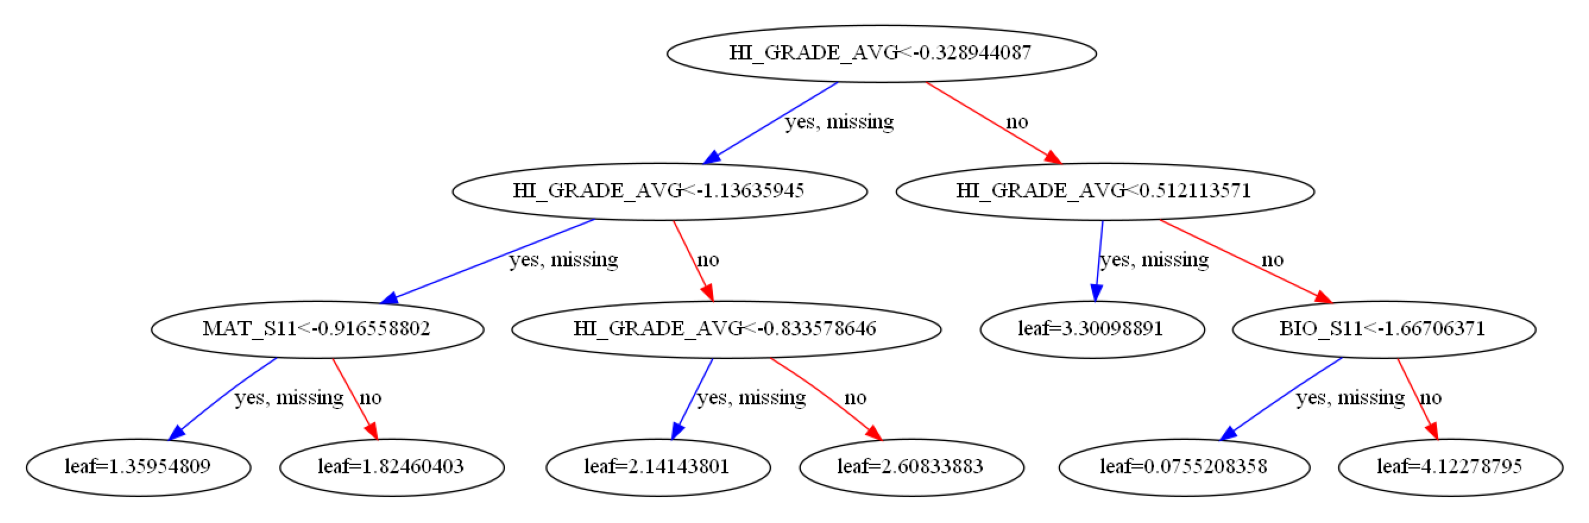

In [136]:

# plot decision tree

from xgboost import plot_tree
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))



plot_tree(final_model,fontsize=10)
# plt.show()
plt.savefig('tree_high_dpi_ex', dpi=400)


In [137]:

# Reparring the index and predictions 
index = X_test.index.to_numpy()
gender = X_test.GENDER_bin.to_numpy()

preds = y_pred_final
listen = list(map(list, zip(index,gender, preds)))

# for later gender 
for_later_gender = gender
# from tempfile import TemporaryFile
# outfile = TemporaryFile()
for_later_gender = np.save('for_later_gender.npy', for_later_gender)    # .npy extension is added if not given


samlet_preds_plain_ex = pd.DataFrame(listen, columns=['Idx','Gender_bins','Preds'])
samlet_preds_plain_ex = samlet_preds_plain_ex.sort_values(by=['Preds'],ascending=False)
samlet_preds_plain_ex.to_csv("samlet_preds_plain_ex.csv")



In [138]:
# df = pd.read_csv("df_sum_score_ex.csv")
# dfs = df.copy()
# mean_col = []
# std_col = []
# col = []
# for column in dfs.columns:
#     try: 
#         mean_col.append(dfs[column].mean())
#         col.append(column)
#         std_col.append(dfs[column].std())
#     except:
#         pass 

# raw_mean_std = pd.DataFrame(
#     {'mean': mean_col,
#      'std': std_col,
#      'col': col
#     })

In [139]:

# #apply standardization to filtered original dataframe
# dfs_rev = samlet_preds_plain_ex.copy()
# dfs_rev

In [140]:
# sorte predictions med mergesort 
import numpy as np

pred_sorted = np.sort(y_pred_final, axis=- 1, kind='mergesort')[::-1]
pred_sorted


# Plotting
import matplotlib as mpl
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

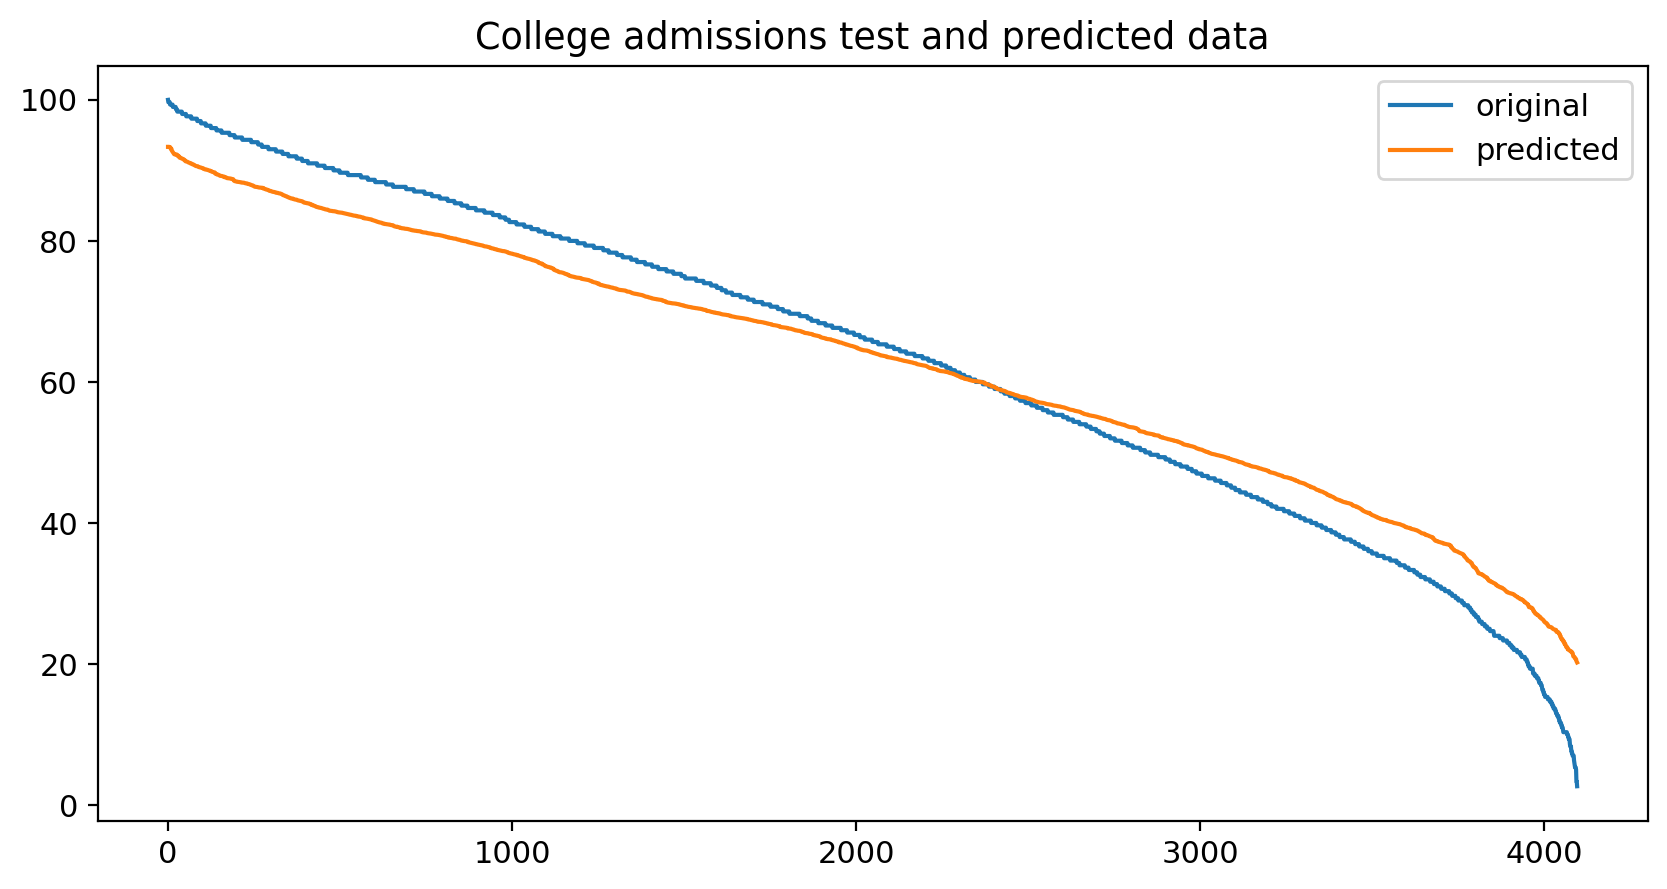

<Figure size 2000x1000 with 0 Axes>

In [141]:

# Plotting
import matplotlib as mpl
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

x_ax = range(len(y_test))
y_test_sorted = np.sort(y_test, axis=- 1, kind='mergesort')[::-1]
plt.plot(x_ax, y_test_sorted, label="original")
plt.plot(x_ax, pred_sorted, label="predicted")
plt.title("College admissions test and predicted data")
plt.legend()
plt.show()
plt.savefig("plot_xgb_plain_ex.png")

In [142]:
# Packages and libraries
import pandas as pd
import xgboost as xgb
import numpy as np

# Load data before standardization
df = pd.read_csv("df_sum_score_ex.csv")
# Splitting the data 
# X is the data which will be used to make predictions, and y contains the data we want to predict.
# We want to predict the score of the students in college, hence y_training and y_test is the college average grade. 

X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_S11','CC_S11','ENG_S11','CR_PRO','CC_PRO','ENG_PRO', 'STRATUM','GENDER_bin','SCHOOL_NAT',	'SCHOOL_TYPE',	'MAT_S11'	,'BIO_S11'], axis=1).copy()
# X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_S11','CC_S11','ENG_S11','CR_PRO','CC_PRO','ENG_PRO'], axis=1).copy() 

y=df['COL_GRADE_AVG'].copy()


# # Now we will continue to formatting X to make it suitable for making a model with XGBoost. 
# # One-hot encoding 

# # Look at the different types of data contained in each variable. 
# X.dtypes

# # The object columns we need to inspect to ensure that they are what we need them to be and after that we will do one-hot encoding. 
# # One hot encoding is used to make the categorical varoiable STRATUM work in the model. 
# # What is gonna happen is that the categorical variable is becoming multiple columns of binary values. 
# # One hot encoding works great for trees and this is the motivation for using this method. 
# X_encoded = pd.get_dummies(X,columns=['STRATUM','SCHOOL_TYPE','SCHOOL_NAT'])
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=24, test_size=0.33)#, stratify=y)

# Standardized dataframe
# Subtract mean and divide by standard deviation

#apply standardization to filtered original dataframe
dfs = df.copy()

for column in dfs.columns:
    try:
        dfs[column] = (dfs[column] - dfs[column].mean())/dfs[column].std()  
    except:
        pass
    
#Check means are 0 and std 1
# print("mean column HI grade: ", dfs.HI_GRADE_AVG.mean(), "std column HI grade: ", dfs.HI_GRADE_AVG.std(),)
# print("mean column COL grade: ", dfs.COL_GRADE_AVG.mean(), "std column COL grade: ", dfs.COL_GRADE_AVG.std(),)

df = dfs

# Regressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
# XGBRegressor

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Prediction
y_pred_init = model.predict(X_test)
y_pred_init
# Mean squared error
# This is the average squared difference between the estimated values and the actual value.
# Kør disse herunder for at se om det er blevet bedre 
mse_init = mean_squared_error(y_test, y_pred_init)

# Root mean squared error
rmse_init= np.sqrt(mse_init)

print("INITIAL MSE: %.2f" % mse_init)
print("INITIAL RMSE: %.2f" % rmse_init)

# # Optimize parameters using cross-validation

# # XGBoost has a lot of hyper parameters which we can manually tune. These are e.g. max_depth of the tree, learning_rate, gamma which encourages pruning of the tree and reg_lambda which is the regularization parameter lambda. We are trying to find the optimal values for these parameters and hope that we can improve the accuracy in the prediction of the candidates college grades. 
# # Gridsearch cross validation 

# # Gridsearch CV will be run sequentially on subsets of different options for the parameters. 

# # 1st round
# param_grid_1 = {
#     'max_depth':[3,4,5],
#     'learning_rate':[0.01,0.05,0.1],
#     'gamma':[0,0.25,0.1],
#     'reg_lambda':[0,0.1,10.0],
#     'scale_pos_weight':[1,3,5]
# }
# from sklearn.model_selection import GridSearchCV


# # base_estimator_model = xgb.XGBRegressor()
# # clf = GridSearchCV(base_estimator_model, param_grid)
# # clf.fit(X_train, y_train)

# optimal_params = GridSearchCV(
#     estimator=xgb.XGBRegressor(
#         objective='reg:squarederror', seed=24, subsample=0.9),
#         param_grid=param_grid_1,
#         cv=5).fit(X_train,y_train)
          
# # optimal parameters 
# print(optimal_params.best_params_)

# ## Round 2 
# param_grid_2 = {
#     'max_depth':[2,3],
#     'learning_rate':[0.05],
#     'gamma':[0,0.01],
#     'reg_lambda':[10.0,15.0,20.0],
#     'scale_pos_weight':[0.01,0.5,1]
# }
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBRegressor(
#         objective='reg:squarederror', seed=24, subsample=0.9),
#         param_grid=param_grid_2,
#         cv=5).fit(X_train,y_train)
# # optimal parameters 
# print(optimal_params.best_params_)
# ## Round 3 
# param_grid_3 = {
#     'max_depth':[3],
#     'learning_rate':[0.05],
#     'gamma':[0],
#     'reg_lambda':[15.0],
#     'scale_pos_weight':[0.01]
# }


final_model = xgb.XGBRegressor(seed=24, objective='reg:squarederror', max_depth=2, learning_rate=0.05, gamma=0,reg_lambda=5.0, scale_pos_weight=0.05)
final_model.fit(X_train,y_train,verbose=True, eval_metric='rmse')
# eval_metric default according to objective
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(final_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# The model is tunes with grid search CV and evaluated using k-fold cross valdiation. The model is 
# evaluated on the training data and the average mean absolut error across the repeats of 10-fold cross-validtaion is reported. 
# There is some variation in the magnitude of errors as seen by theMAE. The average difference between 
# the predicted college garde and the observed college grade was 11.431 points in the grade. 

scores_final = cross_val_score(final_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores_final.mean())

scores = cross_val_score(model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())
y_pred_final = final_model.predict(X_test)
y_pred_final
# Kør disse herunder for at se om det er blevet bedre 
mse_final = mean_squared_error(y_test, y_pred_final)
print("FINAL MSE: %.2f" % mse_final)

# Root mean squared error
rmse_final= np.sqrt(mse_final)
print("FINAL RMSE: %.2f" % rmse_final)

# from sklearn.metrics import average_precision_score
# map_final= average_precision_score(y_test, y_pred_final)
# print("FINAL MAP: %.2f" % map_final)


# Results
# FOR RAW DATA VANILLA 
# Before and after parameter optimization
# - MSE: 219.97  (ændring på -6,44%)
# - FINAL MSE: 205.79


# FOR RAW DATA WITHOUT SENSITIVE 
# - INITIAL MSE: 207.27
# - FINAL MSE: 205.79

# FOR STANDARDIZED DATA 
# - INITIAL MSE: 0.42  (ændring på -4,76%)
# - FINAL MSE: 0.40

# - FINAL MSE: 0.40
# - FINAL RMSE: 0.63

# Reparring the index and predictions 
# X_test
index = X_test.index.to_numpy()
gender = for_later_gender
preds = y_pred_final
listen = list(map(list, zip(index,gender, preds)))


samlet_preds_index_without_sensitive = pd.DataFrame(listen, columns=['Idx','Gender_bins','Preds'])
samlet_preds_index_without_sensitive=samlet_preds_index_without_sensitive.sort_values(by=['Preds'],ascending=False)
samlet_preds_index_without_sensitive.to_csv("samlet_preds_index_without_sensitive_ny.csv")

plot_tree(final_model)
plt.show()

pred_sorted = np.sort(y_pred_final, axis=- 1, kind='mergesort')[::-1]
pred_sorted

# Plotting
import matplotlib as mpl
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

x_ax = range(len(y_test))
y_test_sorted = np.sort(y_test, axis=- 1, kind='mergesort')[::-1]
plt.plot(x_ax, y_test_sorted, label="original")
plt.plot(x_ax, pred_sorted, label="predicted")
plt.title("College admissions test and predicted data")
plt.legend()
plt.show()
plt.savefig("plot_xgb_without sensitive.png")


INITIAL MSE: 207.27
INITIAL RMSE: 14.40
Mean MAE: 11.444 (0.265)
Mean MAE: 11.461 (0.283)
Mean cross-validation score: 0.60
Mean cross-validation score: 0.59
FINAL MSE: 206.28
FINAL RMSE: 14.36


TypeError: 'NoneType' object is not iterable